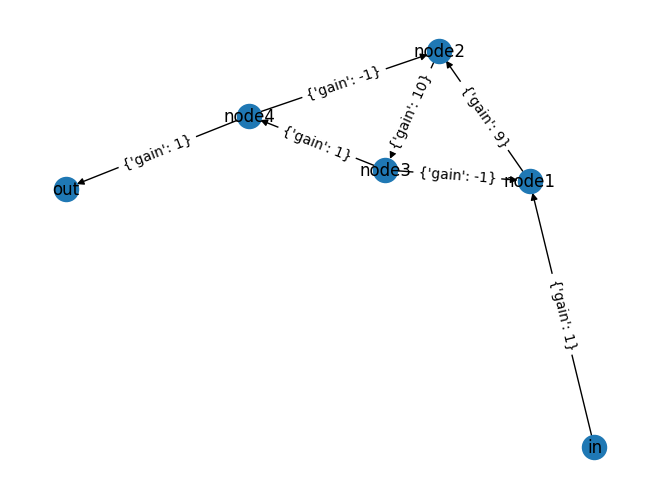

In [3]:
import networkx as nx
import matplotlib.pyplot as plt

g1 = 9
g2 = 10
# Directed Graphの作成
G = nx.DiGraph()

# ノード（加算点または引き出し点）の追加
G.add_node('in')
G.add_node('node1')
G.add_node('node2')
G.add_node('node3')
G.add_node('node4')
G.add_node('out')

# エッジ（ブロック）の追加
G.add_edge('in', 'node1', gain=1)
G.add_edge('node1', 'node2', gain=g1)
G.add_edge('node2', 'node3', gain=g2)
G.add_edge('node3', 'node1', gain=-1)
G.add_edge('node3', 'node4', gain=1)
G.add_edge('node4', 'node2', gain=-1)
G.add_edge('node4', 'out', gain=1)

# グラフの描画
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True)
nx.draw_networkx_edge_labels(G, pos)
plt.show()

In [4]:
import networkx as nx

class PathFinder:
    def __init__(self, G):
        self.G = G
        self.node_to_index = {node: i for i, node in enumerate(G.nodes)}
        self.visited = [False]*len(G.nodes)
        self.paths = []
        self.path_count = [0]

    def count_paths(self, start_node, end_node):
        self.dfs_count_paths(start_node, end_node, [])
        return self.path_count[0], self.paths

    def dfs_count_paths(self, start_node, end_node, path):
        self.visited[self.node_to_index[start_node]] = True
        path.append(start_node)

        if start_node == end_node:
            self.path_count[0] += 1
            self.paths.append(list(path))
        else:
            for node in self.G.neighbors(start_node):
                if not self.visited[self.node_to_index[node]]:
                    self.dfs_count_paths(node, end_node, path)

        path.pop()
        self.visited[self.node_to_index[start_node]] = False

# 閉路を含まない道の数を数える
finder = PathFinder(G)
num_paths, paths = finder.count_paths('in', 'out')
print("Number of acyclic paths:", num_paths)
print("Paths:", paths)

Number of acyclic paths: 1
Paths: [['in', 'node1', 'node2', 'node3', 'node4', 'out']]


In [5]:
class CycleFinder:
    def __init__(self, G):
        self.G = G
        self.node_to_index = {node: i for i, node in enumerate(G.nodes)}
        self.visited = [False]*len(G.nodes)
        self.rec_stack = [False]*len(G.nodes)
        self.cycles = []

    def find_cycles(self):
        for node in self.G.nodes:
            if not self.visited[self.node_to_index[node]]:
                self.dfs_find_cycles(node, [])
        return self.cycles

    def dfs_find_cycles(self, start_node, path):
        self.visited[self.node_to_index[start_node]] = True
        self.rec_stack[self.node_to_index[start_node]] = True
        path.append(start_node)

        for node in self.G.neighbors(start_node):
            if not self.visited[self.node_to_index[node]]:
                self.dfs_find_cycles(node, path)
            elif self.rec_stack[self.node_to_index[node]]:
                cycle = list(path)
                cycle_start = cycle.index(node)
                self.cycles.append(cycle[cycle_start:] + [node])

        path.pop()
        self.rec_stack[self.node_to_index[start_node]] = False

# 閉路を検出する
finder = CycleFinder(G)
cycles = finder.find_cycles()

print("Cycles:", cycles)

Cycles: [['node1', 'node2', 'node3', 'node1'], ['node2', 'node3', 'node4', 'node2']]


In [6]:
import itertools

def find_non_overlapping_combinations(arrays):
    combinations = []
    for r in range(2, len(arrays) + 1):
        for combination in itertools.combinations(arrays, r):
            if not any(set(array1).intersection(array2) for array1, array2 in itertools.combinations(combination, 2)):
                combinations.append(combination)
    return combinations

independent_combos = find_non_overlapping_combinations(cycles)

print("Combinations:", independent_combos)

Combinations: []


In [7]:
def calculate_gain(path, G):
    product = 1
    for i in range(len(path) - 1):
        edge = (path[i], path[i+1])
        if edge in G.edges:
            product *= G.edges[edge]['gain']
    return product

def calculate_total_gain(combos, G):
    total_gain = 1
    for combo in combos:
        for path in combo:
            gain = calculate_gain(path, G)
            total_gain *= gain
    return total_gain

for cycle in cycles:
    print("Cycle:", cycle)
    gain = calculate_gain(cycle, G)
    print("Gain:", gain)

Cycle: ['node1', 'node2', 'node3', 'node1']
Gain: -90
Cycle: ['node2', 'node3', 'node4', 'node2']
Gain: -10


In [8]:
def acum(independent_combos, cycles, G):    
    acum = 1

    for combo in independent_combos:
        acum -= calculate_total_gain([combo], G)

    for cycle in cycles:
        gain = calculate_gain(cycle, G)
        acum -= gain

    return acum

In [9]:
print("Acum:", acum(independent_combos, cycles, G))

Acum: 101


In [10]:
def remove_cycles_containing_path(cycles, path):
    path_set = set(path)
    return [cycle for cycle in cycles if not path_set.intersection(cycle)]

In [11]:
numerator = 0

In [12]:
for path in paths:
    gain = calculate_gain(path, G)
    cycles_path = remove_cycles_containing_path(cycles,path)
    delta_i_combos =  find_non_overlapping_combinations(cycles_path)
    delta_i = acum(delta_i_combos, cycles_path, G)

    numerator += gain * delta_i 

In [13]:
block = numerator / acum(independent_combos, cycles, G)
block

0.8910891089108911